In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import t, shapiro
#from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import cluster, metrics
from sklearn.metrics import mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn_pandas import DataFrameMapper
from sklearn import neighbors
from math import sqrt

In [92]:
df0=pd.read_csv("./Documents/csv/foncier_transformed.csv",
               dtype={'Nature mutation':object, 'Valeur fonciere':np.float64,
                      "Code postal":object ,"Commune":object,"Code departement":object,"Type local":object,
                      "Surface reelle bati":np.float64,"Nombre pieces principales":np.float64,"Surface terrain":np.float64})

In [93]:
df=df0[['Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie','Voie','Code postal', 'Commune', "Code departement",
       'Type local', 'Surface reelle bati','Nombre pieces principales', 'Surface terrain']]

In [94]:
#Changement de format de date
df['Date mutation']=pd.to_datetime(df['Date mutation'])

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_1436/2523924433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date mutation']=pd.to_datetime(df['Date mutation'])


In [95]:
#Liste des départements dans les Pays de la Loire
pdl=["44","49","53","72","85"]
#Filtrage sur les PdL
df=df[df["Code departement"].isin(pdl)]

In [96]:
#Dégrossisage du jeu de données par suppression des lignes redondantes 

#Les dépendances
df.drop(df[df["Type local"]=="Dépendance"].index, inplace=True)

#Suppression de doublons
df.drop_duplicates(subset=["Date mutation","Valeur fonciere","Type de voie","Voie","Code postal","Commune"], inplace=True)

#Suppression des lignes où la valeur foncière est inconnue
df.drop(df[df["Valeur fonciere"].isna()==True].index, inplace=True)

In [97]:
#On ne garde que les colonnes nécessaires à l'algorithme
df=df[["Date mutation","Nature mutation","Code postal" ,"Commune","Code departement","Type local",
       "Surface reelle bati","Nombre pieces principales","Surface terrain","Valeur fonciere"]]

#Sur chaque variable, on regarde celle qui a le plus de nan...
#... et on filtre jusqu'à obtenir un jeu de données sans NaN
df=df[df["Type local"].isna()==False]
df=df[df["Surface terrain"].isna()==False]
df=df[df["Surface reelle bati"].isna()==False]
df=df[df["Code postal"].isna()==False]
#df.isnull().sum()

df.columns = df.columns.str.replace(' ','_')


## Gestion des outliers sur les variables numeriques

<AxesSubplot:xlabel='Valeur_fonciere'>

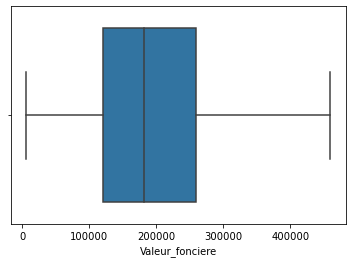

In [98]:
#Pour finir, on ne garde que les valeurs foncieres supérieures à 5000€ et inférieures à pour éviter les outliers
df=df[df['Valeur_fonciere'].astype(float)>5000]
df=df[df['Valeur_fonciere']<460000]
sns.boxplot(x=df["Valeur_fonciere"])

<AxesSubplot:xlabel='Surface_reelle_bati'>

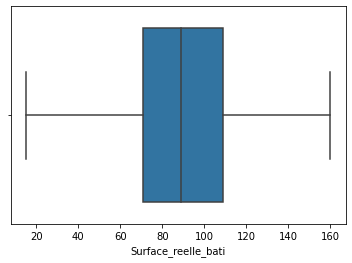

In [99]:
#Idem pour la surface réelle...
df=df[df['Surface_reelle_bati']<=160]
df=df[df['Surface_reelle_bati']>=15]
sns.boxplot(x=df['Surface_reelle_bati'])

<AxesSubplot:xlabel='Nombre_pieces_principales'>

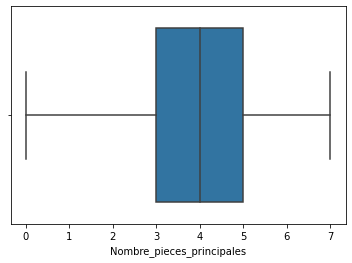

In [100]:
#Pour le nombre de pièces...
df=df[df['Nombre_pieces_principales']<=7]
sns.boxplot(x=df["Nombre_pieces_principales"])

<AxesSubplot:xlabel='Surface_terrain'>

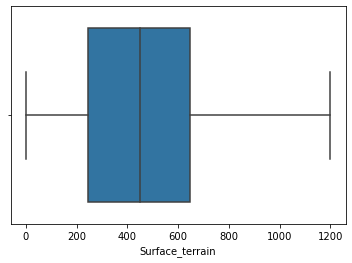

In [101]:
#Et la surface du terrain
df=df[df["Surface_terrain"]<=1200]
sns.boxplot(x=df["Surface_terrain"])

<AxesSubplot:>

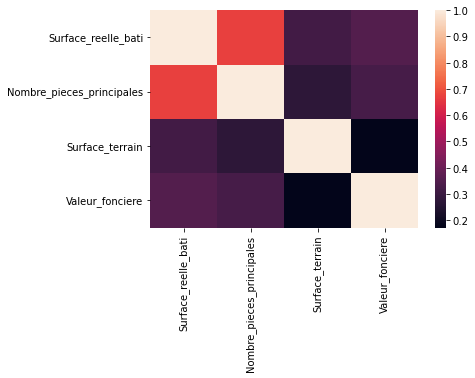

In [102]:
sns.heatmap(df.corr())

# Régression linéaire

In [108]:
X= df.copy()

y=pd.DataFrame(X["Valeur_fonciere"])
X=X.drop(columns=["Valeur_fonciere","Date_mutation"])

#Train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Preprocessing
numeric_features = ['Surface_reelle_bati','Nombre_pieces_principales', 'Surface_terrain']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['Nature_mutation','Commune', 'Code_departement', 'Type_local']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Execution de l'algorithme
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear', LinearRegression())])


lr.fit(X_train, y_train)
print("model score: %.3f" % lr.score(X_test, y_test))

model score: 0.625


## KNN

In [112]:
X=df.copy()

#Dummies pour les variables catégorielles
X=pd.get_dummies(X)
y=X["Valeur_fonciere"]
X=X.drop(columns=["Valeur_fonciere","Date_mutation"])

#Train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#standardisation
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train)
x_train = pd.DataFrame(x_train_scaled)
x_test_scaled = scaler.fit_transform(X_test)
x_test = pd.DataFrame(x_test_scaled)
X

,Surface_reelle_bati,Nombre_pieces_principales,Surface_terrain,Nature_mutation_Adjudication,Nature_mutation_Echange,Nature_mutation_Vente,Nature_mutation_Vente en l'état futur d'achèvement,Nature_mutation_Vente terrain à bâtir,Code_postal_44000.0,Code_postal_44100.0,...,Commune_YVRE LE POLIN,Commune_YZERNAY,Code_departement_44,Code_departement_49,Code_departement_53,Code_departement_72,Code_departement_85,Type_local_Appartement,Type_local_Local industriel. commercial ou assimilé,Type_local_Maison
1441120,129.0,5.0,390.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1441123,40.0,2.0,121.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1441128,44.0,3.0,701.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1441152,110.0,5.0,386.0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1441174,69.0,3.0,407.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850813,120.0,5.0,215.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2850817,84.0,4.0,690.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2850822,54.0,1.0,253.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2850833,94.0,4.0,390.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [124]:
#calcul rmse
model = neighbors.KNeighborsRegressor(n_neighbors=9)
model.fit(x_train,y_train)
pred = model.predict(x_test)
error = sqrt(mean_squared_error(y_test,pred)) 
error

66137.73389496509

#### Sert à déterminer le n_neighbors
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':list(range(1,15))}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
model.best_params_


## Conclusion
La régression linéaire semble plus appropriée que le knn